Sentiment analysis is the process of analyzing data to determine if it is positive, negative, or neutral. Sentiment analysis helps give users an understanding of data in relation to a specific business to understand customer demands. Additionally, we can use it to gauge product sentiment. In this project, I will be performing exploratory data analysis (EDA) on a dataset I found on Kaggle: https://www.kaggle.com/mathurinache/10700-articles-from-new-york-times. This dataset contains information about 10,700 articles (including title and article-snippet information), from the front page of New York Times for years ranging from 2014 to 2019, with most information about articles from 2016 and 2017. After the EDA, I will conduct a sentiment analysis to answer the following question: During the general election of 2016, how many articles mention President Donald Trump and former Secretary of State Hillary Clinton and were they positive or negative? 

I will import some important packages and libraries for this project. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import datetime as dt
import nltk
from nltk.tokenize import word_tokenize
from pprint import pprint

Some are especially important:
- pprint: a "pretty printer" that allows us to output certain data structures in an easy to interpret format.
- NLTK: Natural Language Tool Kit, a platform that allows us to to work with languages and texts. 
- word_tokenize: a package in NLTK that allows us to seperate large strings into individual word strings.  

We run the following line to download NLTK's databases.

In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Exploratory Data Analysis:

Let's load in the dataset from Kaggle and take a quick glimpse at it.

In [4]:
nyt_data = pd.read_csv('C:/Users/Zayaan Syed/Downloads/nytimes front page.csv')

In [5]:
nyt_data.head()

,id,title,author,content,date,year,month,front_page,url,date_counter,stems
0,2,"How the Russia Inquiry Began: A Campaign Aide,...",Sharon LaFraniere,WASHINGTON — During a night of heavy drinking ...,2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/us/politics...,0_2018,washington -- during a night of heavy drinking...
1,3,"For Trump, a Year of Reinventing the Presidenc...",Peter Baker,WASHINGTON — When President Trump meets with a...,2017-12-31,2017.0,12.0,True,https://www.nytimes.com/2017/12/31/us/politics...,0_2018,washington -- when president trump meet with a...
2,4,The U.S. Has Pummeled Al Qaeda in Yemen. But t...,Eric Schmitt,"MANAMA, Bahrain — The United States has triple...",2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/world/middl...,0_2018,"manama , bahrain -- the united states have tri..."
3,5,Why an Upstate Prisoner With a History of Esca...,William K. Rashbaum,The plan sounds ingenious. Remove two small se...,2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/nyregion/da...,0_2018,the plan sound ingenious . remove two small se...
4,6,"In Fire-Scarred Bronx Neighborhood, a World of...",Rick Rojas,"Even on a nose-numbingly cold morning, familie...",2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/nyregion/br...,0_2018,"even on a nose - numbingly cold morning , fami..."


According to the following output, there are no nulls in this dataset. This saves us from having to do some extra data cleaning.

In [6]:
nyt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10732 entries, 0 to 10731
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10732 non-null  int64  
 1   title         10732 non-null  object 
 2   author        10732 non-null  object 
 3   content       10732 non-null  object 
 4   date          10732 non-null  object 
 5   year          10732 non-null  float64
 6   month         10732 non-null  float64
 7   front_page    10732 non-null  bool   
 8   url           10732 non-null  object 
 9   date_counter  10732 non-null  object 
 10  stems         10732 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 849.0+ KB


Let's do a little analysis on the author column. First, I want to group the articles by the author that wrote them.

In [7]:
authors_group = nyt_data.groupby('author')

In [8]:
group_size = authors_group.size()
print(group_size)

author
Aaron M. Kessler                       1
Abby Goodnough                        36
Adam B. Ellick                         1
Adam Goldman                          43
Adam Liptak                          129
                                    ... 
Yonette Joseph                         2
Zabihullah Ghazi                       1
Zach Schonbrun                         8
an Employee of The New York Times      2
Óscar Martínez                         1
Length: 792, dtype: int64


There are 792 authors. I am interested to see who are the top ten publishers:

In [9]:
group_size.sort_values(ascending=False).head(10)

author
Peter Baker               300
Michael D. Shear          287
Mark Landler              209
Julie Hirschfeld Davis    206
Jonathan Martin           152
David E. Sanger           150
Maggie Haberman           143
Adam Liptak               129
Jennifer Steinhauer       124
Matt Flegenheimer         104
dtype: int64

The following line gives us the range of years that the articles were published.

In [15]:
nyt_data.year.unique()

array([2017., 2018., 2016., 2019., 2015., 2014.])

In this part of EDA, I want to see what words were most cited in the titles of the articles. First, I need to join each title in a string. This creates an output of all the titles in one continuous string, separated by a space. Then, we can split that up into a list of words.

In [16]:
sentences_nyt = nyt_data['title'].str.cat(sep = '')

Now, I want to split the continous string into individual word-strings. This makes it easier to analyze and find the most commonly used words. The separation is based on spaces and commas. 

In [17]:
tok_nyt = word_tokenize(sentences_nyt)

Now that we have all the titles broken up into words, we want to remove any words that don't carry much meaning. They are referred to as stop words and consist of words like is, they, it, etc. I also removed words less than or equal to three letters. The code to generate this plot as well as remove the stopwords was largely inspired by this blogger: https://towardsdatascience.com/headlines-articles-analysis-and-nlp-4013a66dbac

In [18]:
import string
string.punctuation
tok_nyt = [char for char in tok_nyt if char not in string.punctuation]
from nltk.corpus import stopwords
# remove stopwords
stop = stopwords.words('english')
tok_nyt = [token for token in tok_nyt if token not in stop]
# remove words less than three letters
tok_nyt = [word for word in tok_nyt if len(word) >= 3]

Let's create a word cloud with the most cited words in titles. I like the idea of a word cloud becuase the visual aspect allows us to better understand mentions of some words in comparison to others.

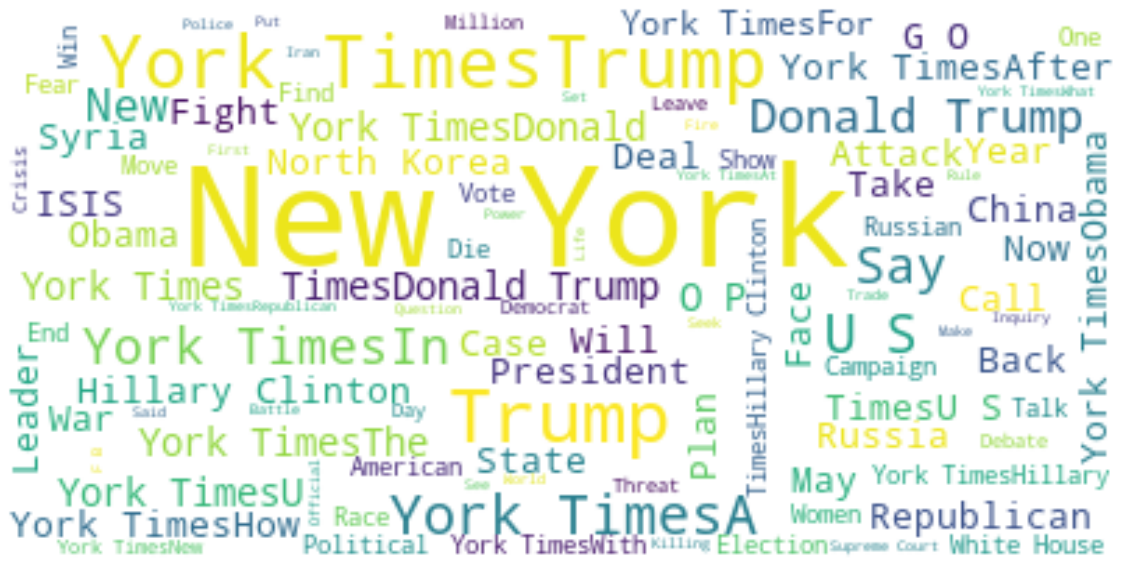

In [19]:
!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
plt.figure(figsize=(20,20))
wc = WordCloud(max_font_size=50, max_words=100, background_color='white')
wordcloud_nyt = wc.generate_from_text(' '.join(tok_nyt))
plt.imshow(wordcloud_nyt, interpolation='bilinear')
plt.axis('off')
plt.show()

The most commonly appearing terms include New York. This is expected since the titles were pulled with "- The New York Times" tagged along at the end. We could have removed that with some extra data cleaning, but it is not a big deal for now. 

Now, lets create a frequency distribution for the most commonly occurring words.

In [20]:
import operator
freq_dis_nyt={}
for tok in tok_nyt:
    if tok in freq_dis_nyt:
        freq_dis_nyt[tok]+= 1
    else:
        freq_dis_nyt[tok]=1

[('New', 11210), ('York', 10916), ('The', 10842), ('Trump', 1649), ('TimesTrump', 863), ('With', 605), ('From', 418), ('Says', 391), ('TimesIn', 374), ('Over', 359), ('Clinton', 348), ('His', 318), ('Donald', 318), ('U.S.', 310), ('Are', 296), ('TimesA', 279), ('After', 275), ('Times', 261), ('Not', 244), ('House', 237), ('Health', 226), ('That', 225), ('Russia', 223), ('TimesThe', 221), ('TimesDonald', 215), ('Deal', 204), ('Tax', 194), ('Court', 191), ('May', 190), ('Korea', 188), ('ISIS', 187), ('TimesU.S', 187), ('Will', 184), ('North', 182), ('Against', 179), ('TimesHow', 178), ('Obama', 177), ('TimesAs', 175), ('Its', 174), ('Was', 170), ('Bill', 168), ('Say', 162), ('G.O.P', 161), ('More', 159), ('Hillary', 159), ('Plan', 157), ('Attack', 155), ('China', 153), ('War', 152), ('Campaign', 147), ('Has', 145), ('Into', 145), ('Out', 145), ('Who', 144), ('Syria', 144), ('TimesAfter', 143), ('TimesObama', 142), ('Case', 141), ('About', 138), ('Fight', 137), ('Police', 135), ('Now', 13

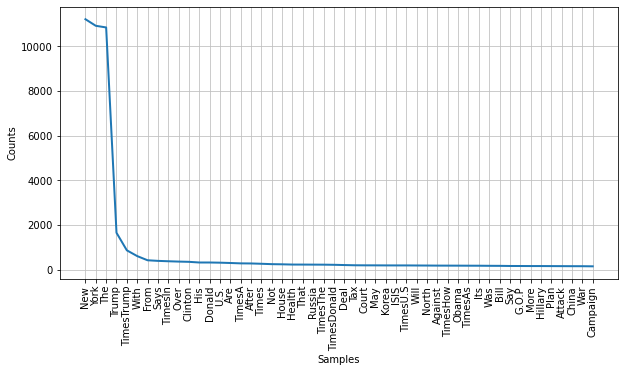

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [55]:
# We want to sort this dictionary on values ( freq in this case )
sorted_freq_nyt = sorted(freq_dis_nyt.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_freq_nyt[:100])
plt.figure(figsize=(10, 5))
Freq_dist_nltk=nltk.FreqDist(tok_nyt)
Freq_dist_nltk.plot(50, cumulative=False)

Again, we see that "New," "York," and "Times" are the most commonly occurring words, which does cause a little bit of noise. Additionally from out top 100 word list several notable countries were mentioned multiple times. They are the U.S. (310 times), Russia (223 times), Korea (188 times), China (153 times), Syria (144 times), and Iran (119 times). It makes sense that Russa and Korea are the top mentioned countries due to their presence in the World Cup in 2018. Additionally, Russia's involvement in the 2016 election definitely caused an uptick in article mentions. 

Now, let's take a look at popular publishing days and months.

In [22]:
nyt_data['date'] = pd.to_datetime(nyt_data['date'])

In [23]:
nyt_data['day_of_week'] = nyt_data['date'].dt.day_name()

In [24]:
nyt_data.head()

,id,title,author,content,date,year,month,front_page,url,date_counter,stems,day_of_week
0,2,"How the Russia Inquiry Began: A Campaign Aide,...",Sharon LaFraniere,WASHINGTON — During a night of heavy drinking ...,2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/us/politics...,0_2018,washington -- during a night of heavy drinking...,Saturday
1,3,"For Trump, a Year of Reinventing the Presidenc...",Peter Baker,WASHINGTON — When President Trump meets with a...,2017-12-31,2017.0,12.0,True,https://www.nytimes.com/2017/12/31/us/politics...,0_2018,washington -- when president trump meet with a...,Sunday
2,4,The U.S. Has Pummeled Al Qaeda in Yemen. But t...,Eric Schmitt,"MANAMA, Bahrain — The United States has triple...",2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/world/middl...,0_2018,"manama , bahrain -- the united states have tri...",Saturday
3,5,Why an Upstate Prisoner With a History of Esca...,William K. Rashbaum,The plan sounds ingenious. Remove two small se...,2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/nyregion/da...,0_2018,the plan sound ingenious . remove two small se...,Saturday
4,6,"In Fire-Scarred Bronx Neighborhood, a World of...",Rick Rojas,"Even on a nose-numbingly cold morning, familie...",2017-12-30,2017.0,12.0,True,https://www.nytimes.com/2017/12/30/nyregion/br...,0_2018,"even on a nose - numbingly cold morning , fami...",Saturday


Most articles were published on Wednesday.

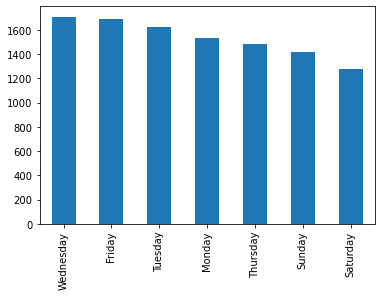

In [25]:
nyt_data['day_of_week'].value_counts().plot(kind='bar');

A majority of the articles were published in 2017. This also explains why Russia was one of the most mentioned countries, due to their mentions in the aftermath of the 2016 elections which also extended into 2017. 

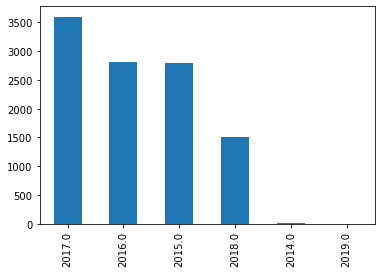

In [26]:
nyt_data['year'].value_counts().plot(kind='bar');

Articles were published more in January than any other month.

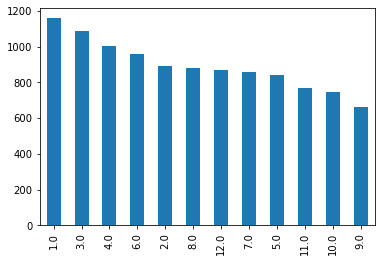

In [27]:
nyt_data['month'].value_counts().plot(kind='bar');

Sentiment Analysis

I need to filter out the year 2016 from the dataset because that is the year of the general election. The code used to do so was largely inspired by the authors of these two posts: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/ and https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6. With that, I will be able to answer the following question: During the general election of 2016, how many articles mention President Donald Trump and former Secretary of State Hillary Clinton and were they positive or negative? 

In [90]:
_2016 = nyt_data[nyt_data['date'].dt.year == 2016]

We are applying the same method as earlier to find out how many titles mentioned "Clinton" or "Trump." First, we need to condense the titles into one continous string seperated by spaces. Then, we use the word_tokenize() function to further parse the large strings into individual words.

In [111]:
sentences_nyt16 = _2016['title'].str.cat(sep = ' ')

In [92]:
sentences_nyt16a = _2016['title']

In [113]:
tok_nyt16 = word_tokenize(sentences_nyt16)

In [114]:
import string
string.punctuation
tok_nyt16 = [char for char in tok_nyt16 if char not in string.punctuation]
from nltk.corpus import stopwords
# remove stopwords
stop = stopwords.words('english')
tok_nyt16 = [token for token in tok_nyt16 if token not in stop]
# remove words less than three letters
tok_nyt16 = [word for word in tok_nyt16 if len(word) >= 3]

In [115]:
import operator
freq_dis_nyt16={}
for tok in tok_nyt16:
    if tok in freq_dis_nyt16:
        freq_dis_nyt16[tok]+= 1
    else:
        freq_dis_nyt16[tok]=1

In [116]:
sorted_freq_nyt16 = sorted(freq_dis_nyt16.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_freq_nyt16[:25])

[('New', 2962), ('The', 2893), ('York', 2857), ('Times', 2825), ('Trump', 702), ('Donald', 463), ('Clinton', 241), ('Hillary', 192), ('With', 176), ('Obama', 132), ('From', 107), ('After', 107), ('U.S.', 106), ('How', 95), ('Over', 95), ('Says', 91), ('His', 88), ('Sanders', 77), ('Campaign', 73), ('Bernie', 68), ('What', 66), ('Court', 66), ('ISIS', 65), ('Are', 63), ('Debate', 58)]


We can see that "Trump" was mentioned 702 times and "Clinton" was mentioned 241 times in the year of the presidential election (2016). This answers our first question.

VADER (Valence Aware Dictionary and sEntiment Reasoner) is an analytical tool from NLTK that uses a lexicon of positive and negative words to rank words based on whether they are positive, negative, or neutral and to what degree. We create a sentiment intensity analyzer to categorize the titles of the articles and then use polarity_scores to get the sentiment. We'll then take all this information and create a dataframe out of it.

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [42]:
sia = SIA()
results = []

for line in sentences_nyt16a:
    pol_score = sia.polarity_scores(line)
    pol_score['title'] = line
    results.append(pol_score)
    
pprint(results[:70], width=100)

[{'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'title': 'How the Government Classifies Secrets - The New York Times'},
 {'compound': -0.4404,
  'neg': 0.172,
  'neu': 0.828,
  'pos': 0.0,
  'title': 'Vladimir Putin Won’t Expel U.S. Diplomats as Russian Foreign Minister Urged - The New '
           'York Times'},
 {'compound': -0.296,
  'neg': 0.136,
  'neu': 0.864,
  'pos': 0.0,
  'title': 'Trump Gets an Opening from Russia, but the Path Is Risky - The New York Times'},
 {'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'title': 'Theresa May Scolds Kerry for Focus on Israel Settlements - The New York Times'},
 {'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'title': 'China Bans Its Ivory Trade, Moving Against Elephant Poaching - The New York Times'},
 {'compound': -0.6705,
  'neg': 0.243,
  'neu': 0.757,
  'pos': 0.0,
  'title': 'Rift Between Officers and Residents as Killings Persist in South Bronx - The New York '
           'Times'},
 {'comp

The data frame below includes a column called "compound" that scores the overall sentiment. It ranges from -1 to 1. Compound scores that are greater than 0.2 will be considered positive, from -0.2 to 0.2 will be considered neutral, and less than -0.2 will be considered negative.

In [43]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,title
0,0.000,1.000,0.0,0.0000,How the Government Classifies Secrets - The Ne...
1,0.172,0.828,0.0,-0.4404,Vladimir Putin Won’t Expel U.S. Diplomats as R...
2,0.136,0.864,0.0,-0.2960,"Trump Gets an Opening from Russia, but the Pat..."
3,0.000,1.000,0.0,0.0000,Theresa May Scolds Kerry for Focus on Israel S...
4,0.000,1.000,0.0,0.0000,"China Bans Its Ivory Trade, Moving Against Ele..."


We will create labels that tell us if the sentiment is negative, positive, or neutral. The positive label will be 1 if the compound is greater than 0.2, -1 if the compoud is less than -.2, and 0 otherwise.

In [44]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,neg,neu,pos,compound,title,label
0,0.000,1.000,0.0,0.0000,How the Government Classifies Secrets - The Ne...,0
1,0.172,0.828,0.0,-0.4404,Vladimir Putin Won’t Expel U.S. Diplomats as R...,-1
2,0.136,0.864,0.0,-0.2960,"Trump Gets an Opening from Russia, but the Pat...",-1
3,0.000,1.000,0.0,0.0000,Theresa May Scolds Kerry for Focus on Israel S...,0
4,0.000,1.000,0.0,0.0000,"China Bans Its Ivory Trade, Moving Against Ele...",0


Let us save this information we need into a csv file. This csv file contains all the article titles in 2016 and their respective lables.

In [45]:
df2 = df[['title', 'label']]
df2.to_csv('nyt_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

Using pretty print, we print the first five titles that are positive and negative from our saved csv file. 

In [98]:
print("Positive titles:\n")
pprint(list(df[df['label'] == 1].title)[:5], width=200)

print("\nNegative titles:\n")
pprint(list(df[df['label'] == -1].title)[:5], width=200)

Positive titles:

['In Trump’s New Year Note, Love and a Jab at ‘Enemies’ - The New York Times',
 'How Russians Pay to Play in Other Countries - The New York Times',
 'House Republicans Fret About Winning Their Health Care Suit - The New York Times',
 'Trump Promises a Revelation on Hacking - The New York Times',
 'Scientists Loved and Loathed by an Agrochemical Giant - The New York Times']

Negative titles:

['Vladimir Putin Won’t Expel U.S. Diplomats as Russian Foreign Minister Urged - The New York Times',
 'Trump Gets an Opening from Russia, but the Path Is Risky - The New York Times',
 'Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times',
 'Along Mosul’s Front Line, Desperate Civilians and Dug-In Troops and Fighters - The New York Times',
 'Terrorist Attack at Nightclub in Istanbul Kills Dozens - The New York Times']


I want to see how many positives,negatives, and neutrals we have in this dataset. The second output gives the same information in the form of percentages.

In [117]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

 0    1250
-1    1031
 1     534
Name: label, dtype: int64
 0    44.404973
-1    36.625222
 1    18.969805
Name: label, dtype: float64


Just as before, we need to preprocess our data in order to analyze it. We will tokenize the text, but this time we will also use the RegexpTokenizer function. This will also allow us to remove punctuation from our tokenized text, which I had not done before.

In [48]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [49]:
tokenizer = RegexpTokenizer(r'\w+')

In [50]:
from nltk.corpus import stopwords

Again, removing stopwords. 

In [51]:
stop_words = stopwords.words('english')

The following function will remove stopwords, implement lowercasing, and tokenzing on our list of titles.

In [52]:
def process_text(title):
    tokens = []
    for line in title:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

Now we can retrieve the most common words in positive headlines by using the FreqDist function from NLTK. 

In [53]:
pos_lines = list(df[df.label == 1].title)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('new', 562),
 ('york', 545),
 ('times', 536),
 ('trump', 143),
 ('donald', 93),
 ('clinton', 53),
 ('court', 47),
 ('hillary', 46),
 ('supreme', 45),
 ('obama', 32),
 ('u', 28),
 ('bernie', 21),
 ('sanders', 21),
 ('wins', 20),
 ('p', 19),
 ('g', 18),
 ('win', 17),
 ('justice', 15),
 ('party', 14),
 ('cruz', 13)]

... and the same for negatives.

In [54]:
neg_lines = list(df2[df2.label == -1].title)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('new', 1085),
 ('york', 1044),
 ('times', 1035),
 ('trump', 213),
 ('donald', 148),
 ('u', 73),
 ('clinton', 60),
 ('hillary', 49),
 ('isis', 43),
 ('attack', 38),
 ('obama', 38),
 ('says', 37),
 ('fight', 33),
 ('war', 31),
 ('police', 29),
 ('attacks', 26),
 ('say', 25),
 ('russia', 23),
 ('n', 23),
 ('amid', 21)]

We can see that "trump" was most common in both negative and positive headlines. However, it was mentioned 70 times more in negative titles. This difference accounts for about 19% of mentions for the total amount of "trump" mentions in positive and negative headlines combined.  "clinton" was mentioned second most common in both positive and negative headlines. However, it was mentioned 7 more times in negative titles. This difference accounts for about 6% of mentions for the total amount of "clinton" mentions in positive and negative headlines combined. "trump" and "clinton" were mentioned in the positive list along with words like "win" and "justice," which makes sense because articles covered what parties won and in what state.